# Terra/Gen3 Reconciliation

> Render summary results from dashboard notebook

In [1]:
# setup
# !pip install ipywidgets==8.0.0a0 upsetjs_jupyter_widget
# !jupyter nbextension install --py upsetjs_jupyter_widget --user
# !jupyter nbextension enable --py upsetjs_jupyter_widget --user

import datetime
import json
import os
from anvil.util.reconciler import flatten
import pandas as pd
from ipywidgets import interact
from upsetjs_jupyter_widget import UpSetJSWidget
import matplotlib.pyplot as plt
from pprint import pprint

# set width to 100% to make easier to show wide upset plot
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

## Retrieve dashboard summary data

In [4]:

# open output summary from reconcilier
DASHBOARD_OUTPUT_PATH = "/tmp"
TERRA_SUMMARY = f"{DASHBOARD_OUTPUT_PATH}/terra_summary.json"
DASHBOARD_OUTPUT_FILE = f"{DASHBOARD_OUTPUT_PATH}/data_dashboard.json"

assert os.path.isfile(DASHBOARD_OUTPUT_FILE), "dashboard should exist"
with open(DASHBOARD_OUTPUT_FILE, 'r') as inputs:
    dashboard_data = json.load(inputs)
        
# Flatten dashboard into tsv, show the tsv
(flattened, column_names) = flatten(dashboard_data['projects'])
df = pd.DataFrame(flattened)  
df.columns = column_names
df    

,source,workspace,accession,Bai,Bam,Crai,Cram,Md5,Tbi,Vcf,...,Subject,dbgap_sample_count_mismatch,inconsistent_entityName,inconsistent_subject,missing_accession,missing_blobs,missing_samples,missing_schema,missing_sequence,missing_subjects
0,CMG,AnVIL_CMG_Broad_Muscle_KNC_WGS,phs001272.v1.p1,,,,,,,,...,14,,,,,,,,True,
1,CMG,ANVIL_CMG_Broad_Muscle_Laing_WES,phs001272.v1.p1,,,,,,,,...,31,,,,,,,,True,
2,CMG,AnVIL_CMG_Broad_Orphan_VCGS-White_WES,phs001272.v1.p1,,,,,,,,...,447,,,,,,,,True,
3,CMG,AnVIL_CMG_Broad_Muscle_Myoseq_WES,phs001272.v1.p1,,,,,,,,...,1280,,,,,,,,True,
4,CMG,AnVIL_CMG_Broad_Heart_Ware_WES,phs001272.v1.p1,,,,,,,,...,10,,,,,,,,True,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,dbGAP,phs001395.v1.p1,phs001395.v1.p1,,,,,,,,...,,True,,,,,,,,
232,dbGAP,phs001624.v1.p1,phs001624.v1.p1,,,,,,,,...,,True,,,,,,,,
233,dbGAP,phs001545.v1.p1,phs001545.v1.p1,,,,,,,,...,,True,,,,,,,,
234,dbGAP,phs000997.v4.p2,phs000997.v4.p2,,,,,,,,...,,True,,,,,,,,


## Consolidate key metrics

In [5]:
# consolidate key metrics
def sizeof_fmt(num, suffix='B'):
    """Human readable size from bytes size."""
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


df_sum = df[df['source']!='dbGAP'].groupby(['source']).agg(['sum'])
df_sum.columns = df_sum.columns.droplevel(1)

df_sum['Size'] = df_sum['size'].apply(lambda x: sizeof_fmt(x))
df_sum = df_sum.drop(['workspace', 'dbgap_sample_count_mismatch', 'Bai', 'Bam', 'Tbi','Vcf', 'size'], axis='columns')
df_sum


,Project,Samples,Subject,Size
source,,,,
CCDG,174,237671,175568,989.8TiB
CMG,37,9690,8968,74.6GiB
GTEx,1,17382,979,91.7TiB
ThousandGenomes,1,3202,3202,65.1TiB


## Summarize data wrangling exceptions

* `inconsistent_entityName`
    The majority of workspaces in this consortium use a {'entityName': ...} structure.  This workspace does not.

*  `missing_subjects`
    This workspace has no subjects.

*  `missing_sequence`
    The majority of workspaces in this consortium use a sequence entity to link sample to blobs(files).  This workspace does not.

*  `dbgap_sample_count_mismatch`
    The count of samples in all workspaces tagged with this accession does not match the length of DbGap/Study/SampleList provided by dbGap's API.

* `missing_accession`
    This workspace does not have an accession.

*  `inconsistent_subject`
    The majority of workspaces in this consortium use a consistent key in the sample to refer to the subject.  This workspace does not.
    * For CCDG this is a misspelling of 'participant'.
    * For CMG this is refers to inconsistent use of '01-subject_id'.


* `missing_samples`
    At least one subject in this workspace is missing a sample.

* `missing_schema`
    The terra API (list_entity_types)[https://github.com/broadinstitute/fiss/blob/0440e4822a49c393e65964d9dedaa6d4828587bd/firecloud/api.py#L180] returned null.

* `missing_blobs`
    At least one sample in this workspace is missing a blob.

In [6]:
# summarize problems

flattened = []
problems = set([problem for project in dashboard_data['projects'] for problem in project['problems']])
for problem in problems:
    projects = [project['project_id'] for project in dashboard_data['projects'] if problem in project['problems']]
    flattened.append([problem, ','.join(projects)])

# Print the data  (all rows, all columns)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'left')

df = pd.DataFrame(flattened)  
df.columns = ['problem', 'affected_workspaces']
df = df.style.set_properties(**{'text-align': 'left'})
df 

,problem,affected_workspaces
0,inconsistent_subject,"AnVIL_CMG_Broad_Muscle_Topf_WES,AnVIL_CMG_UWash_GRU,AnVIL_CMG_Broad_Blood_Gazda_WES,AnVIL_CCDG_WashU_CVD-NP-AI_Controls_VCControls_WGS"
1,missing_subjects,"AnVIL_CMG_Broad_Blood_Gazda_WGS,AnVIL_CMG_Broad_Brain_Gleeson_WGS,AnVIL_CMG_Broad_Brain_Engle_WGS,AnVIL_CMG_Broad_Kidney_Pollak_WES,AnVIL_CMG_Broad_Orphan_Scott_WES,AnVIL_CMG_Broad_Blood_Fleming_WES,AnVIL_CCDG_Freeze2_VCFAggregation,AnVIL_CCDG_WashU_CVD_EOCAD_BioImage_WGS,AnVIL_CCDG_WASHU_PAGE,AnVIL_CCDG_Freeze2_VCFs,ANVIL_CCDG_Broad_CVD_EOCAD_PROMIS_ARRAY,AnVIL_CCDG_Broad_Deposit"
2,dbgap_sample_count_mismatch,"phs001272.v1.p1,phs001489.v1.p1,phs001642.v1.p1,phs001222.v1.p1,phs001227.v1.p1,phs001259.v1.p1,phs001543.v1.p1,phs001544.v1.p1,phs000160.v1.p1,phs001676.v1.p1,phs001502.v1.p1,phs001062.v4.p2,phs001180.v2.p1,phs000496.v1.p1,phs001395.v1.p1,phs001624.v1.p1,phs001545.v1.p1,phs000997.v4.p2,phs001398.v1.p1"
3,missing_sequence,"AnVIL_CMG_Broad_Muscle_KNC_WGS,ANVIL_CMG_Broad_Muscle_Laing_WES,AnVIL_CMG_Broad_Orphan_VCGS-White_WES,AnVIL_CMG_Broad_Muscle_Myoseq_WES,AnVIL_CMG_Broad_Heart_Ware_WES,AnVIL_CMG_Broad_Muscle_Beggs_WES,AnVIL_CMG_Broad_Orphan_Estonia-Ounap_WES,AnVIL_CMG_Broad_Eye_Pierce_WES,AnVIL_CMG_Broad_Orphan_Estonia-Ounap_WGS,AnVIL_CMG_Broad_Muscle_Topf_WES,AnVIL_CMG_Broad_Blood_Sankaran_WES,AnVIL_CMG_Broad_Brain_Walsh_WES,AnVIL_CMG_Broad_Muscle_Kang_WES,AnVIL_CMG_Broad_Kidney_Hildebrandt_WES,AnVIL_CMG_Broad_Muscle_OGrady_WES,AnVIL_CMG_Broad_Brain_Gleeson_WES,AnVIL_CMG_Broad_Kidney_Hildebrandt_WGS,AnVIL_CMG_Broad_Orphan_Manton_WES,AnVIL_CMG_Broad_Heart_PCGC-Tristani_WGS,AnVIL_CMG_Broad_Muscle_KNC_WES,AnVIL_CMG_Broad_Heart_Seidman_WES,AnVIL_CMG_Broad_Muscle_Bonnemann_WGS,AnVIL_CMG_Broad_Muscle_Bonnemann_WES,AnVIL_CMG_Broad_Orphan_Manton_WGS,AnVIL_CMG_Broad_Muscle_Ravenscroft_WES,AnVIL_CMG_Broad_Orphan_VCGS-White_WGS,AnVIL_CMG_Broad_Muscle_Myoseq_WGS,AnVIL_CMG_Broad_Muscle_Kang_WGS,AnVIL_CMG_Broad_Eye_Pierce_WGS"
4,missing_samples,"AnVIL_CMG_Broad_Blood_Gazda_WGS,AnVIL_CMG_Broad_Brain_Gleeson_WGS,AnVIL_CMG_Broad_Brain_Engle_WGS,AnVIL_CMG_Broad_Kidney_Pollak_WES,AnVIL_CMG_Broad_Orphan_Scott_WES,AnVIL_CMG_Broad_Blood_Fleming_WES,AnVIL_CCDG_WashU_CVD_EOCAD_METSIM_WGS,AnVIL_CCDG_NYGC_NP_Autism_ACE2_DS-MDS_WGS,AnVIL_CCDG_WASHU_PAGE,AnVIL_CCDG_Broad_AI_IBD_Cho_WGS,AnVIL_CCDG_NYGC_NP_Autism_SAGE_WGS,AnVIL_CCDG_Baylor_CVD_HemStroke_ERICH_WGS,AnVIL_CCDG_Baylor_CVD_EOCAD_SoL_WGS,AnVIL_CCDG_Freeze2_VCFs,AnVIL_CCDG_WashU_CVD_EOCAD_WashU-CAD_DS_WGS,AnVIL_CCDG_WashU_CVD_EOCAD_Emory_WGS,AnVIL_CCDG_NYGC_NP_Autism_ACE2_GRU-MDS_WGS,ANVIL_CCDG_Broad_CVD_EOCAD_PROMIS_ARRAY,AnVIL_CCDG_Baylor_CVD_ARIC,AnVIL_CCDG_Broad_Deposit,AnVIL_GTEx_V8_hg38"
5,inconsistent_entityName,"AnVIL_CCDG_WashU_AI_T1D_T1DGC_WGS,AnVIL_CCDG_WashU_CVD_EOCAD_Harvard-Costa-Rica_WGS,AnVIL_CCDG_NYGC_NP_Autism_SSC_WGS,AnVIL_CCDG_WashU_CVD-NP-AI_Controls_VCControls_WGS"
6,missing_blobs,"AnVIL_CMG_Broad_Blood_Gazda_WGS,AnVIL_CMG_Broad_Brain_Gleeson_WGS,AnVIL_CMG_Broad_Brain_Engle_WGS,AnVIL_CMG_Broad_Kidney_Pollak_WES,AnVIL_CMG_Broad_Orphan_Scott_WES,AnVIL_CMG_Broad_Blood_Fleming_WES,AnVIL_CCDG_WashU_CVD_EOCAD_Harvard-Costa-Rica_WGS,AnVIL_CCDG_Broad_NP_Epilepsy_DEUUPM_HMB_MDS_WES,AnVIL_CCDG_Broad_NP_Epilepsy_USAUPN_GRU_NPU_WES,AnVIL_CCDG_Broad_AI_IBD_McGovern_WGS,AnVIL_ccdg_asc_ndd_daly_talkowski_AGRE-FEMF_asd_exome,AnVIL_CCDG_Broad_NP_Epilepsy_LEBABM_GRU_WES,ANVIL_CCDG_Broad_CVD_EOCAD_PROMIS_ARRAY,AnVIL_CCDG_WashU_CVD-NP-AI_Controls_VCControls_WGS,AnVIL_CCDG_Broad_Deposit"
7,missing_schema,"AnVIL_CMG_Broad_Blood_Gazda_WGS,AnVIL_CMG_Broad_Brain_Gleeson_WGS,AnVIL_CMG_Broad_Brain_Engle_WGS,AnVIL_CMG_Broad_Kidney_Pollak_WES,AnVIL_CMG_Broad_Orphan_Scott_WES,AnVIL_CMG_Broad_Blood_Fleming_WES,AnVIL_CCDG_WASHU_PAGE,AnVIL_CCDG_Freeze2_VCFs,ANVIL_CCDG_Broad_CVD_EOCAD_PROMIS_ARRAY,AnVIL_CCDG_Broad_Deposit"
8,missing_accession,"AnVIL_CCDG_WashU_CVD_EOCAD_BioMe_WGS,AnVIL_CCDG_Broad_CVD_AFib_Penn_WGS,AnVIL_CCDG_WashU_CVD_EOCAD_METSIM_WGS,ANVIL_CCDG_Broad_CVD_EOCAD_PROMIS_ARRAY,An

## Data wrangling: Interactive Upset Plot

In [9]:
# 

flattened = {}
problems = set([problem for project in dashboard_data['projects'] for problem in project['problems']])
for problem in problems:
    projects = [project['project_id'] for project in dashboard_data['projects'] if problem in project['problems'] and project['project_id'] != 'dbGAP']
    if len(projects):
        flattened[problem] = projects

w = UpSetJSWidget[str](bar_label=1)   
w.from_dict(flattened)


def show_set(_set):
    """Display set."""
    pprint(_set.name)
    pprint(list(_set.elems))            
    

def selection_changed(s):
    """Callback from widget. """
    if s:
        if 'sets' in dir(s):
            for _set in s.sets:
                show_set(_set)
        else:
                show_set(s)            
    return None

interact(selection_changed, s=w)

plt.show()



interactive(children=(UpSetJSWidget(value=None, combinations=[UpSetSetIntersection(name=missing_sequence, sets…

## Show Gen3 Terra reconciliation

In [8]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('/tmp/gen3-drs.sqlite')
cur = conn.cursor()

df = pd.read_sql_query("""
SELECT count(project_id) as \"workspace_count\", 'missing_terra_project_id' as \"exception\" from summary where anvil_project_id is null
UNION
SELECT count(*) as \"workspace_count\", 'unimported_terra_project' as \"exception\" from reconcile_counts where gen3_sample_id_count = 0
UNION
SELECT count(*) as \"workspace_count\", 'sample_count_mismatch' as \"exception\" from reconcile_counts where gen3_sample_id_count > 0 and gen3_sample_id_count <> terra_sample_id_count
UNION
SELECT count(*) as \"workspace_count\", 'successful_import' as \"exception\"  from reconcile_counts where terra_sample_id_count = gen3_sample_id_count and terra_blob_count = gen3_drs_uri_count;
""", conn, index_col="exception")
df

,workspace_count
exception,
successful_import,8
missing_terra_project_id,10
sample_count_mismatch,16
unimported_terra_project,154


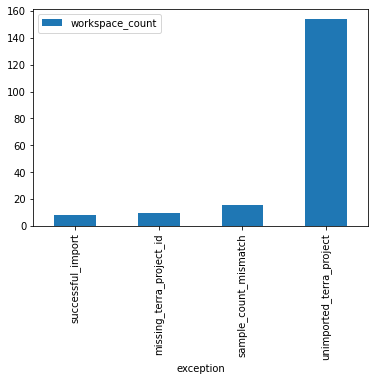

In [24]:
df.plot(kind="bar" )
plt.show()